In [7]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)


logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

INFO     | __main__:<module>:21 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:22 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [8]:
# =============================================================================
# BRIAN2 SETUP
# =============================================================================
from brian2 import *

# Performance optimization for standalone compilation
os.environ['CXXFLAGS'] = '-fopenmp -O3'
os.environ['LDFLAGS'] = '-lgomp'

# Clean slate
restore_initial_state()

# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================
# Options: 'runtime', 'cpp_standalone', 'cuda_standalone'
DEVICE_MODE = 'runtime'  # Change this for performance

# Hardware detection
import multiprocessing
N_CORES = multiprocessing.cpu_count()
logger.info(f"Available CPU cores: {N_CORES}")

if DEVICE_MODE == 'cpp_standalone':
    set_device('cpp_standalone', directory='brian2_output', build_on_run=True)
    prefs.devices.cpp_standalone.openmp_threads = min(N_CORES, 20)  # Adaptive
    logger.info(f"[DEVICE] cpp_standalone with {prefs.devices.cpp_standalone.openmp_threads} threads")

elif DEVICE_MODE == 'cuda_standalone':
    try:
        # from brian2cuda import *  # Uncomment if available
        set_device('cuda_standalone', directory='brian2_cuda_output', build_on_run=False)
        logger.info("[DEVICE] cuda_standalone enabled")
    except ImportError:
        logger.error("[WARNING] brian2cuda not available, falling back to cpp_standalone")
        set_device('cpp_standalone', directory='brian2_output', build_on_run=True)
        
else:  # runtime
    logger.warning(f"[DEVICE] runtime mode (single-threaded)")

logger.info(f"Brian2 device: {get_device()}")
logger.info("=" * 60)

INFO       Available CPU cores: 12 [brian2]
WARNING    [DEVICE] runtime mode (single-threaded) [brian2]
INFO       Brian2 device: <brian2.devices.device.RuntimeDevice object at 0x7fc075cf27d0> [brian2]
INFO       ============================================================ [brian2]


In [9]:
def get_uniform_delays(prefix):
    """Uniform delay distributions with different ranges"""
    return {
        f'{prefix}_uniform_0-6': {'type': 'uniform', 'params': {'low': 0.0, 'high': 6.0}},
        f'{prefix}_uniform_0p75-5p25': {'type': 'uniform', 'params': {'low': 0.75, 'high': 5.25}},
        f'{prefix}_uniform_1p5-4p5': {'type': 'uniform', 'params': {'low': 1.5, 'high': 4.5}},
        f'{prefix}_uniform_2p25-3p75': {'type': 'uniform', 'params': {'low': 2.25, 'high': 3.75}},
    }

def get_lognormal_delays(prefix):
    """Lognormal delay distributions"""
    return {
        f'{prefix}_lognorm_3-1': {'type': 'lognormal', 'params': {'alpha': 1.0, 'beta': 0.3}},
        f'{prefix}_lognorm_6-1p5': {'type': 'lognormal', 'params': {'alpha': 1.8, 'beta': 0.5}},
        f'{prefix}_lognorm_3-2': {'type': 'lognormal', 'params': {'alpha': 1.0, 'beta': 0.7}},
    }

def get_gamma_delays(prefix):
    """Gamma delay distributions"""
    return {
        f'{prefix}_gamma_3-1': {'type': 'gamma', 'params': {'shape': 3.0, 'scale': 1.0}},
        f'{prefix}_gamma_5-0p8': {'type': 'gamma', 'params': {'shape': 5.0, 'scale': 0.8}},
        f'{prefix}_gamma_2-2': {'type': 'gamma', 'params': {'shape': 2.0, 'scale': 2.0}},
    }

def get_delta_delays(prefix):
    """Constant delay values"""
    return {
        f'{prefix}_delta_0': {'type': 'constant', 'value': 0.0},
        f'{prefix}_delta_2': {'type': 'constant', 'value': 4.0},
        f'{prefix}_delta_4': {'type': 'constant', 'value': 6.0},
        f'{prefix}_delta_6': {'type': 'constant', 'value': 8.0},
        f'{prefix}_delta_0': {'type': 'constant', 'value': 12.0},
        f'{prefix}_delta_2': {'type': 'constant', 'value': 16.0},
        f'{prefix}_delta_4': {'type': 'constant', 'value': 20.0},
    }

def get_beta_delays(prefix):
    """Beta delay distributions with different shapes"""
    return {
        f'{prefix}_beta_symmetric': {'type': 'beta', 'params': {'alpha': 2.0, 'beta': 2.0, 'scale': 6.0}},
        f'{prefix}_beta_fast_bias': {'type': 'beta', 'params': {'alpha': 1.0, 'beta': 3.0, 'scale': 6.0}},
        f'{prefix}_beta_slow_bias': {'type': 'beta', 'params': {'alpha': 3.0, 'beta': 1.0, 'scale': 6.0}},
        f'{prefix}_beta_U_shape': {'type': 'beta', 'params': {'alpha': 0.5, 'beta': 0.5, 'scale': 6.0}},
    }

In [83]:
list(8*np.sqrt(np.array(np.linspace(0.01, 1.0,20))))

[np.float64(0.8),
 np.float64(1.993674206610815),
 np.float64(2.703603832703772),
 np.float64(3.2625466320522976),
 np.float64(3.7388430521246883),
 np.float64(4.160971546469204),
 np.float64(4.544053372555342),
 np.float64(4.8972602437216715),
 np.float64(5.226652345128965),
 np.float64(5.536481877415239),
 np.float64(5.829868645265743),
 np.float64(6.10918204534436),
 np.float64(6.376271802963167),
 np.float64(6.632614789611139),
 np.float64(6.879412459612643),
 np.float64(7.117657805175727),
 np.float64(7.34818273273632),
 np.float64(7.571692434046002),
 np.float64(7.788790866231725),
 np.float64(8.0)]

In [102]:
# =============================================================================
# PLOT AUTOCORRELATION BY INTERNAL COUPLING
# =============================================================================
import matplotlib.pyplot as plt

def plot_ac_by_internal_k(ac_data, sweep_dir, k_B_fixed, n_trials,
                          p_intra, intra_delay, inter_k_factor,
                          delay_value, noise_int, noise_inh_factor):
    """Plot AC de A y B en función de k interno de A con info de configuración."""
    
    k_values = sorted(ac_data.keys())
    colors = plt.cm.plasma(np.linspace(0, 0.9, len(k_values)))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # === Panel A (ROI A) ===
    for k_A, color in zip(k_values, colors):
        ac = ac_data[k_A]
        axes[0].plot(ac['lags_A'], ac['ac_A_mean'],
                     color=color, linewidth=2, alpha=0.9,
                     label=f'k_A={k_A:.1f}')
        axes[0].fill_between(ac['lags_A'],
                             ac['ac_A_mean'] - ac['ac_A_std'],
                             ac['ac_A_mean'] + ac['ac_A_std'],
                             color=color, alpha=0.2)
    
    axes[0].set_xlabel('Lag (ms)', fontsize=11)
    axes[0].set_ylabel('Autocorrelation', fontsize=11)
    axes[0].set_title('ROI A (varying internal k)', fontsize=12)
    axes[0].legend(fontsize=8, ncol=2)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(-20, 20)
    axes[0].axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # === Panel B (ROI B) ===
    for k_A, color in zip(k_values, colors):
        ac = ac_data[k_A]
        axes[1].plot(ac['lags_B'], ac['ac_B_mean'],
                     color=color, linewidth=2, alpha=0.9,
                     label=f'k_A={k_A:.1f}')
        axes[1].fill_between(ac['lags_B'],
                             ac['ac_B_mean'] - ac['ac_B_std'],
                             ac['ac_B_mean'] + ac['ac_B_std'],
                             color=color, alpha=0.2)
    
    axes[1].set_xlabel('Lag (ms)', fontsize=11)
    axes[1].set_ylabel('Autocorrelation', fontsize=11)
    axes[1].set_title(f'ROI B (fixed k_B={k_B_fixed:.1f})', fontsize=12)
    axes[1].legend(fontsize=8, ncol=2)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(-20, 20)
    axes[1].axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # === Metadata en el título ===
    metadata_text = (
        f"n={n_trials} trials | "
        f"p_intra={p_intra:.2f}, intra_delay={intra_delay:.1f} ms | "
        f"inter_k_factor={inter_k_factor:.1f} | delay_value={delay_value:.1f} ms | "
        f"noise_exc={noise_int:.1f}, noise_inh_factor={noise_inh_factor:.2f}"
    )
    
    plt.suptitle(f"Autocorrelation vs A Internal Coupling Strength\n{metadata_text}",
                 fontsize=11, y=1.03)
    plt.tight_layout()
    
    # === Nombre de archivo más informativo ===
    fig_name = (f"autocorr_by_kA_p{p_intra:.2f}_delay{intra_delay:.1f}_"
                f"inter{inter_k_factor:.1f}_dval{delay_value:.1f}.png")
    fig_path = sweep_dir / fig_name
    
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    logger.info(f"Saved: {fig_path}")
    
    return fig


# =============================================================================
# LOAD AND AVERAGE RESULTS
# =============================================================================
import pandas as pd

def load_and_average_ac_by_k(sweep_dir, n_trials=10):
    """Cargar y promediar AC agrupadas por k_A"""
    ac_by_k = {}
    
    for config_dir in sorted(sweep_dir.iterdir()):
        if not config_dir.is_dir():
            continue
        
        all_lags_A, all_ac_A = [], []
        all_lags_B, all_ac_B = [], []
        k_A = None
        
        for trial_idx in range(n_trials):
            trial_file = config_dir / f'trial_{trial_idx+1}.pkl'
            if not trial_file.exists():
                continue
            
            with open(trial_file, 'rb') as f:
                trial = pickle.load(f)
            
            if k_A is None:
                k_A = trial['k_A']
            
            ac_A = trial.get('autocorr_A', {})
            if 'lags' in ac_A:
                all_lags_A.append(ac_A['lags'])
                all_ac_A.append(ac_A['correlation'])
            
            ac_B = trial.get('autocorr_B', {})
            if 'lags' in ac_B:
                all_lags_B.append(ac_B['lags'])
                all_ac_B.append(ac_B['correlation'])
        
        if len(all_ac_A) > 0 and k_A is not None:
            ac_by_k[k_A] = {
                'lags_A': all_lags_A[0],
                'ac_A_mean': np.mean(all_ac_A, axis=0),
                'ac_A_std': np.std(all_ac_A, axis=0),
                'lags_B': all_lags_B[0],
                'ac_B_mean': np.mean(all_ac_B, axis=0),
                'ac_B_std': np.std(all_ac_B, axis=0),
                'n_trials': len(all_ac_A)
            }
    
    return ac_by_k

In [89]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pickle
import numpy as np
from datetime import datetime
import logging

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results

logger = logging.getLogger(__name__)

# =============================================================================
# FUNCION DE SIMULACIÓN
# =============================================================================
def run_single_trial(config, trial_idx, SIM_CONFIG, Ne, Ni, sweep_dir):
    """Ejecuta un solo trial de un barrido de parámetros."""
    from brian2 import start_scope  # importante si usas Brian2
    
    config_name = config['config_name']
    k_A = config['k_A']
    
    config_dir = sweep_dir / config_name
    config_dir.mkdir(exist_ok=True)

    logger.info(f"[{config_name}] Trial {trial_idx+1} started")

    start_scope()
    network = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=100,
        variable_seed=200 + trial_idx,
        trial=trial_idx
    )

    pop_A = network.create_population('A', **config['params']['pop_A'])
    pop_B = network.create_population('B', **config['params']['pop_B'])

    conn = config['params']['connection']
    syn_AB = network.connect_populations(
        'A', 'B',
        p_inter=conn['p_inter'],
        weight_scale=conn['weight_scale'],
        delay_dist=conn['delay_dist'],
        delay_params=conn['delay_params'],
        delay_value=conn['delay_value']
    )

    network.setup_monitors(['A', 'B'], record_v_dt=0.5, sample_fraction=0.5)
    results = network.run_simulation()

    analysis = analyze_simulation_results(
        results['A']['spike_monitor'],
        results['B']['spike_monitor'],
        Ne + Ni, config_name,
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={'A': network.monitors['A'], 'B': network.monitors['B']},
        delays={'AB': np.array(results['delays_AB']), 'BA': None},
        signal_mode='lfp'
    )

    trial_data = {
        'config_name': config_name,
        'k_A': k_A,
        'trial': trial_idx,
        'time': analysis['time_series']['time'],
        'rate_A': analysis['time_series']['fr_A'],
        'rate_B': analysis['time_series']['fr_B'],
        'autocorr_A': analysis['autocorr_A'],
        'autocorr_B': analysis['autocorr_B'],
        'cross_correlation': analysis['cross_correlation']
    }

    with open(config_dir / f'trial_{trial_idx+1}.pkl', 'wb') as f:
        pickle.dump(trial_data, f)

    logger.info(f"[{config_name}] Trial {trial_idx+1} done")
    return trial_data


In [143]:
# =============================================================================
# SWEEP CONFIGURATION
# =============================================================================
import numpy as np

# Parámetros del sweep
k_internal_values = [0, 0.2, 0.5, 0.8 , 1.5 , 2.5, 3.5, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]
n_trials = 10

# Parámetros comunes
noise_int = 5.0 * 1.0
noise_inh_factor = 0.45
inter_k_factor = 0.5
k_B_fixed = 0.5  # k interno fijo para B
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 4000
delay_value = 0.0

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}

# Base network parameters
NETWORK_PARAMS_BASE = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        # k_exc y k_inh se varían en el sweep
        'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
        'p_intra': p_intra, 'delay': intra_delay,
        'noise_type': 'gaussian',
        'step': False
    },
    'pop_B': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': k_B_fixed*0.5, 'k_inh': k_B_fixed*1.0,
        'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
        'p_intra': p_intra, 'delay': intra_delay,
        'noise_type': 'gaussian',
        'step': False
    },
    'connection': {
        'p_inter': 0.02,
        'weight_scale': inter_k_factor*k_B_fixed,  # Basado en k de B
        'delay_dist': 'constant',
        'delay_params': {},
        'delay_value': delay_value
    }
}

# Sweep configs
SWEEP_CONFIGS = []
for k_A in k_internal_values:
    config = {
        'config_name': f'k_internal_A_{k_A:.1f}_k_inter_{inter_k_factor:.1f}_intra_delay_{intra_delay:.1f}_k_internal_B_{k_B_fixed:.1f}',
        'k_A': k_A,
        'params': {
            'pop_A': {**NETWORK_PARAMS_BASE['pop_A'], 
                     'k_exc': k_A*0.5, 'k_inh': k_A*1.0},
            'pop_B': NETWORK_PARAMS_BASE['pop_B'],
            'connection': NETWORK_PARAMS_BASE['connection']
        }
    }
    SWEEP_CONFIGS.append(config)

logger.info(f"Sweep configured: {len(SWEEP_CONFIGS)} configs × {n_trials} trials")

SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 200, 'variable_base_B': 202, 'variable_base_common': 201, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 201, 'variable_base_B': 203, 'variable_base_common': 202, 'variable_common_current': 208, 'variable_A_current': 208, 'variable_B_current': 211}
DEBUG    | src.two_pop

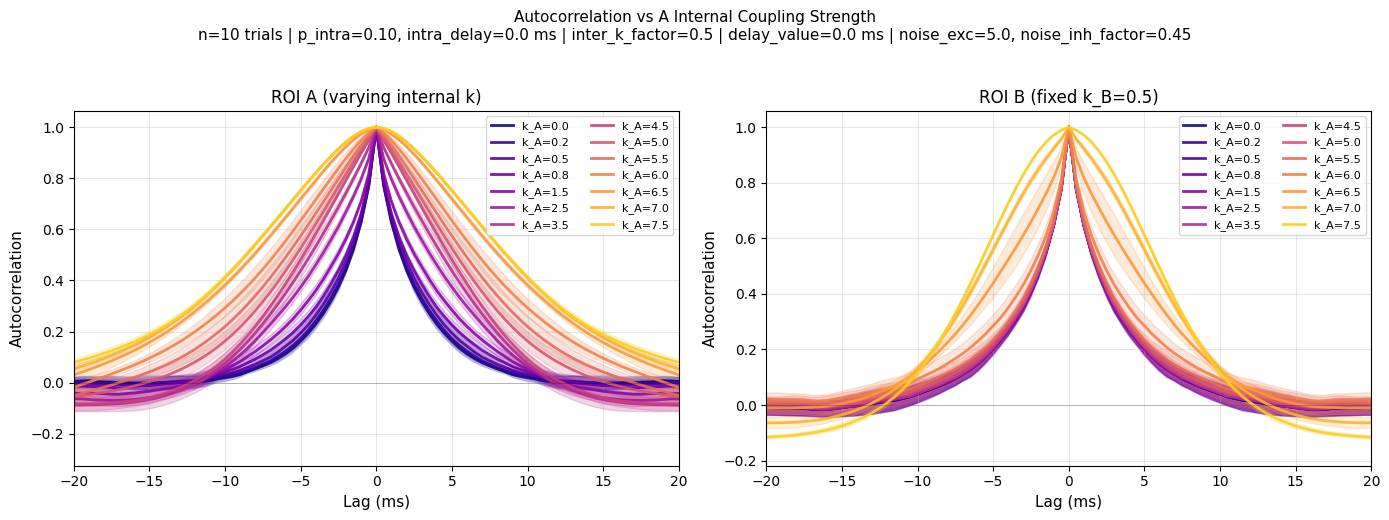

In [144]:
# =============================================================================
# RUN SWEEP EN PARALELO
# =============================================================================
from concurrent.futures import ProcessPoolExecutor, as_completed

# Output directory
output_dir = Path('./results/experiments/two_populations/intra_coupling_sweep')
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sweep_dir = output_dir / timestamp
sweep_dir.mkdir(parents=True, exist_ok=True)

# Save sweep config
with open(sweep_dir / 'sweep_config.pkl', 'wb') as f:
    pickle.dump({
        'k_values': k_internal_values,
        'n_trials': n_trials,
        'sim_config': SIM_CONFIG,
        'base_params': NETWORK_PARAMS_BASE
    }, f)

logger.info(f"Output: {sweep_dir}")

n_workers = 10  # ajusta según tus cores (por ej. os.cpu_count())

tasks = []
for config in SWEEP_CONFIGS:
    for trial_idx in range(n_trials):
        tasks.append((config, trial_idx, SIM_CONFIG, Ne, Ni, sweep_dir))

logger.info(f"Lanzando {len(tasks)} simulaciones en paralelo ({n_workers} procesos)")

all_results = []
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    futures = [executor.submit(run_single_trial, *t) for t in tasks]
    for i, future in enumerate(as_completed(futures), 1):
        try:
            result = future.result()
            all_results.append(result)
            logger.info(f"Completado {i}/{len(tasks)}")
        except Exception as e:
            logger.error(f"Error en tarea {i}: {e}")

logger.info(f"\n{'='*60}")
logger.info(f"SWEEP COMPLETE: {len(all_results)} trials guardados")
logger.info(f"{'='*60}")

# Cargar datos
ac_data = load_and_average_ac_by_k(sweep_dir, n_trials=n_trials)
logger.info(f"Loaded {len(ac_data)} k values")

fig = plot_ac_by_internal_k(
    ac_data, sweep_dir,
    k_B_fixed=k_B_fixed,
    n_trials=n_trials,
    p_intra=p_intra,
    intra_delay=intra_delay,
    inter_k_factor=inter_k_factor,
    delay_value=delay_value,
    noise_int=noise_int,
    noise_inh_factor=noise_inh_factor
)
plt.show()
